## Protótipo I - Sistema de recomendação baseado em modelos de <i>Machine Learning</i>

Nesse notebook, teremos o desenvolvimento da primeira parte prática, do projeto relacionado ao TCC de tema e título acima citado.

In [40]:
# CONSTANTES

PATH_TO_FULL_CF_FILE = "preprocessed-data/CF/data_cf.pkl"

PATH_TO_MOVIES_CF_FILE = "preprocessed-data/CF/movies_cf.pkl"

PATH_TO_RATINGS_CF_FILE = "preprocessed-data/CF/ratings_cf.pkl"




PATH_TO_FULL_CB_FILE = "preprocessed-data/CB/data_cb.pkl"

PATH_TO_MOVIES_CB_FILE = "preprocessed-data/CB/movies_cb.pkl"

PATH_TO_RATINGS_CB_FILE = "preprocessed-data/CB/ratings_cb.pkl"

PATH_TO_RATINGS_INFOS_CB_FILE = "preprocessed-data/CB/ratings_info_cb.pkl"

PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE = "preprocessed-data/CB/tag_relevance_grouped_cb.pkl"

PATH_TO_TAG_RELEVANCE_CB_FILE = "preprocessed-data/CB/tag_relevance_cb.pkl"

PATH_TO_TAGS_PROCESSED_CB_FILE = "preprocessed-data/CB/tags_processed_cb.pkl"

In [41]:
# Importando bibliotecas necessárias
import pandas as pd
pd.set_option("display.max_rows", 25)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import sys
!{sys.executable} -m pip install imdbpy

from imdb import IMDb

# Importando garbage collector
import gc

# Importando bibliotecas para o sistema de recomendação
from scipy.sparse import csr_matrix # Matriz esparsa

from sklearn.neighbors import NearestNeighbors

# Importando Regular Expression operations
import re

## Um pouco sobre o dataset:

O dataset tem 6 arquivos a serem carregados.

O primeiro arquivo é o "<i>ratings.csv</i>".

Nesse arquivo estão contidas todas as avaliações dadas a um filme (identificado pelo campo <b><i>movieID</i></b>), por um usuário (identificado pelo campo <b><i>userId</i></b>). 

A tabela tem as seguintes colunas: userId, movieId, rating, timestamp".

As notas dadas estão numa escala "5 estrelas", com incrementos de "meia estrela". (0.5 estrelas - 5.0 estrelas).

Timestamp, que está contido na tabela representa segundos desde meia noite (UTC) de Janeiro de 1970.

-------------------------------------------------------------------------------------------------------------------------------

O segundo arquivo é o "<i>movies.csv</i>".

Nesse arquivo estão contidas todas as informações sobre os filmes, para cada <b><i>movieID\d</i></b> temos um <i>title</i> e <i>genres</i> atribuidos a ele.

A tabela tem as seguintes colunas: movieId, title, genres.

A lista de generos possíveis é a seguinte:
<ul> 
    <li>Action</li>
    <li>Adventure</li>
    <li>Animation</li>
    <li>Children's</li>
    <li>Comedy</li>
    <li>Crime</li>
    <li>Documentary</li>
    <li>Drama</li>
    <li>Fantasy</li>
    <li>Film-Noir</li>
    <li>Horror</li>
    <li>Musical</li>
    <li>Mystery</li>
    <li>Romance</li>
    <li>Sci-Fi</li>
    <li>Thriller</li>
    <li>War</li>
    <li>Western</li>
    <li>(no genres listed)</li>
</ul>

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

O terceiro arquivo é o "<i>tags.csv</i>".

Nesse arquivo estão contidas todas as tags aplicadas pelos usuários aos filmes, para cada <b><i>movieID</i></b> temos uma <i>tag</i> atribuida a ele.

A tabela tem as seguintes colunas: userId, movieId, tag, timestamp.

Tags são metadados gerados pelos usuários para cada filme. Cada tag é uma palavra ou frase curta.

Timestamp, que está contido na tabela representa segundos desde meia noite (UTC) de Janeiro de 1970.

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

O quarto arquivo é o "<i>links.csv</i>".

Esse arquivo é ótimo para associar os dados que temos com outras fontes de dados, pois, cada linha tem os campos: movieId, imdbId, tmdbId. Ou seja, ele associa os filmes que temos com seus respectivos Ids em outras duas plataformas (imdb e themoviedb).

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

Por ultimo temos o dito "Tag Genome" ("<i>genome-scores.csv e genome-tags.csv</i>".

Tag Genome é uma estrutura de dados que contem pontuações de relevância para cada tag. É basicamente uma matriz (filmes x tags), onde cada filme no genoma tem um valor para cada tag. Essa matriz foi feita utilizando um algoritmo de machine learning sob dados obtidos de usuários, incluindo tags, avaliações e reviews textuais.


Informações sobre o dataset retiradas de: https://files.grouplens.org/datasets/movielens/ml-25m-README.html

### 1 - Preparação dos dados para Collaborative Filtering

Nesse primeiro momento, iremos utilizar os dados sobre as avaliações e sobre os filmes para criar uma matriz filmes x usuário, com as notas dadas.

Para resumir e relembrar, filtragem colaborativa leva em consideração a semelhança entre usuários ou entre itens para realizar uma recomendação, nada além disso. Por isso criaremos essa matriz de relação.

In [42]:
# Carregando arquivos CSV necessários para essa abordagem
data_ratings = pd.read_csv("dataset/ml-25m/ratings.csv")
data_movies = pd.read_csv("dataset/ml-25m/movies.csv")

In [43]:
# Exibindo registros inciais de ratings
data_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [44]:
# Verificando quantas avaliações temos
print(data_ratings.shape[0])

25000095


In [45]:
# Exibindo registros inciais de movies
data_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [46]:
# Removendo os anos dos titulos dos filmes utilizando expressões regulares

#Pegando os anos dos titulos e colocando numa nova coluna
data_movies['year'] = data_movies.title.str.extract('(\(\d\d\d\d\))', expand = False)
#Removendo os parênteses
data_movies['year'] = data_movies.year.str.extract('(\d\d\d\d)', expand = False)
#Removendo os anos da coluna de titulos
data_movies['title'] = data_movies.title.str.replace('(\(\d\d\d\d\))', '', regex=True)
#Garantindo que não tenha nenhum espaço sobrando
data_movies['title'] = data_movies['title'].apply(lambda x: x.strip())

data_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [47]:
# Verificando se algum valor ficou faltante
print(data_movies.isnull().sum())

movieId      0
title        0
genres       0
year       410
dtype: int64


In [48]:
# Percebemos que 410 filmes não tinham o ano registrado em seus títulos, vamos atribuir a esses filmes o valor 0 ao ano
# e posteriormente podemos tratar melhor essas ocorrências

# Primeiro vamos converter os anos para o tipo String, para facilitar a comparação
data_movies["year"] = data_movies["year"].astype(str)

# Aqui vamos percorrer as linhas e substituir os valores faltantes para 0
for row in data_movies.itertuples():
    if(row.year == 'nan'):
        data_movies.at[row.Index, "year"] = 0
        

# Verificando novamente se existe algum valor nulo, após converter para int
data_movies["year"].astype(int)

data_movies.isnull().sum()

movieId    0
title      0
genres     0
year       0
dtype: int64

In [49]:
# Verificando quantos filmes temos
print(data_movies.shape[0])

62423


In [50]:
# Verficando de fato quantos filmes temos
print(data_movies["title"].value_counts())

Cinderella                 16
Hamlet                      9
Home                        9
First Love                  9
The Escape                  8
                           ..
Story of Ruth, The          1
No Nukes                    1
Fagbug                      1
Attila                      1
Women of Devil's Island     1
Name: title, Length: 58529, dtype: int64


Nota-se que alguns filmes estão repetidos, porém não é necessário removê-los agora, visto que esse problema irá se resolver durante o nosso processamento.

#### Problemas observados: 

Como observado acima, temos alguns problemas, considerando uma abordagem Colaborativa, não precisamos das colunas "timestamp" presente em "ratings" e nem das colunas "genres" e "year" presente em "movies". Portanto vamos removê-las.

In [51]:
movies_cf = data_movies.loc[:, {"movieId", "title"}]
ratings_cf = data_ratings.loc[:, {"userId", "movieId", "rating"}]

In [52]:
print("Movies: ")
# Salvando DataFrame de Filmes para collaborative filtering
movies_cf.to_pickle(PATH_TO_MOVIES_CF_FILE)

movies_cf.head()

Movies: 


,movieId,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [53]:
print("Ratings: ")
# Salvando DataFrame de Ratings para collaborative filtering
ratings_cf.to_pickle(PATH_TO_RATINGS_CF_FILE)

ratings_cf.head()

Ratings: 


,movieId,userId,rating
0,296,1,5.0
1,306,1,3.5
2,307,1,5.0
3,665,1,5.0
4,899,1,3.5


Agora iremos juntar os dois dataframes e criar uma matriz usuário x filme.

In [54]:
# Juntando DataFrames
data_cf = pd.merge(movies_cf, ratings_cf)
data_cf.head()

,movieId,title,userId,rating
0,1,Toy Story,2,3.5
1,1,Toy Story,3,4.0
2,1,Toy Story,4,3.0
3,1,Toy Story,5,4.0
4,1,Toy Story,8,4.0


In [55]:
# Salvando DataFrame para Collaborative Filtering
data_cf.to_pickle(PATH_TO_FULL_CF_FILE)

Nesse ponto temos uma matriz que pode ser utilizada, por exemplo, para o treinamento de um modelo que utiliza o KNN (K Nearest Neighbors) como algoritmo.

### 2 - Preparação dos dados para Content-Based

In [56]:
data_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [38]:
data_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Na abordagem content-based, trabalhamos bastante com as semelhanças entre itens, no nosso caso filmes, no que diz respeito as suas características (ano, diretor, gênero, sinopse e etc).

Dessa forma, a primeira coisa que podemos fazer é separar o título que está no formato Titulo (ANO), e construir duas colunas, uma título e uma com o ano. Para isso vamos utilizar expressões regulares.

In [39]:
# criando uma copia do DataFrame sobre os filmes
movies_cb = data_movies.copy()

In [18]:
# verificando se existem filmes duplicados
movies_cb["title"].value_counts().sort_values()

Figaro and Cleo                                                                               1
City of the Living Dead (a.k.a. Gates of Hell, The) (Paura nella città dei morti viventi)     1
Endless Summer, The                                                                           1
Blow-Out (La grande bouffe)                                                                   1
The Slipper and the Rose: The Story of Cinderella                                             1
                                                                                             ..
The Escape                                                                                    8
First Love                                                                                    9
Home                                                                                          9
Hamlet                                                                                        9
Cinderella                              

Nota-se que temos filmes duplicados no dataset, vamos então remove-los posteriormente

In [19]:
# Removendo os anos dos titulos dos filmes utilizando expressões regulares

#Pegando os anos dos titulos e colocando numa nova coluna
data_movies['year'] = data_movies.title.str.extract('(\(\d\d\d\d\))', expand = False)
#Removendo os parênteses
data_movies['year'] = data_movies.year.str.extract('(\d\d\d\d)', expand = False)
#Removendo os anos da coluna de titulos
data_movies['title'] = data_movies.title.str.replace('(\(\d\d\d\d\))', '', regex=True)
#Garantindo que não tenha nenhum espaço sobrando
data_movies['title'] = data_movies['title'].apply(lambda x: x.strip())

data_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,NaN
1,2,Jumanji,Adventure|Children|Fantasy,NaN
2,3,Grumpier Old Men,Comedy|Romance,NaN
3,4,Waiting to Exhale,Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II,Comedy,NaN


#### Modificando a forma com que os gêneros são apresentados

Observando agora a coluna "genres", podemos perceber que o formato apresentado é um pouco complicado para uso, portanto vamos fazer algumas mudanças e conversões.

Vamos transformar cada gênero numa coluna para melhorar isso, e se, o filme é daquele gênero, a coluna recebe o valor "1", caso contrario "0", dessa forma temos:

In [11]:
# Substituindo os gêneros por listas
movies_cb['genres'] = movies_cb['genres'].str.split('|')


movies_cb.tail(10)

,movieId,title,genres
62413,209145,Liberté (2019),[Drama]
62414,209147,The Carpet of Horror (1962),"[Crime, Horror]"
62415,209151,Mao Zedong 1949 (2019),[(no genres listed)]
62416,209153,Happy Flight (2008),"[Comedy, Drama]"
62417,209155,Santosh Subramaniam (2008),"[Action, Comedy, Romance]"
62418,209157,We (2018),[Drama]
62419,209159,Window of the Soul (2001),[Documentary]
62420,209163,Bad Poems (2018),"[Comedy, Drama]"
62421,209169,A Girl Thing (2001),[(no genres listed)]
62422,209171,Women of Devil's Island (1962),"[Action, Adventure, Drama]"


In [12]:
movies_cb.value_counts("movieId")

movieId
1         1
162130    1
162070    1
162072    1
162074    1
         ..
107614    1
107623    1
107625    1
107630    1
209171    1
Length: 62423, dtype: int64

In [13]:
# Salvando DataFrame de Filmes para Content Based
movies_cb.to_pickle(PATH_TO_MOVIES_CB_FILE)

#### Vamos agora juntar o DataFrame modificado com algumas informações que serão retiradas do Dataframe "ratings", porém antes, precisamos modificar o DataFrame "ratings" e remover seu campo "timestamps", calcular o rating médio para cada filme e verificar quantos votos cada filme tem.

In [14]:
# Pegando apenas colunas relevantes de "ratings" - removemos timestamps
ratings_cb = data_ratings.drop("timestamp", axis='columns')
ratings_cb.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [15]:
# Salvando DataFrame de ratings para Content Based
ratings_cb.to_pickle(PATH_TO_RATINGS_CB_FILE)

In [16]:
# Quantos usuarios participaram - 162541
ratings_cb["userId"].value_counts().sort_values()

36207        20
31691        20
135005       20
135012       20
51779        20
          ...  
20055      7488
33844      7919
137293     8913
80974      9178
72315     32202
Name: userId, Length: 162541, dtype: int64

In [17]:
# Contando quantos filmes temos no total - 59047
ratings_cb["movieId"].value_counts().sort_values()

200728        1
188153        1
194576        1
182439        1
178255        1
          ...  
2571      72674
593       74127
296       79672
318       81482
356       81491
Name: movieId, Length: 59047, dtype: int64

Nota-se que aqui temos menos que o valor inicial, isso se deve aos filmes repetidos na lista. (Porém o problema foi resolvido agora).

A maioria dos filmes com nota máxima ou mínima tem pouquissimos votos (geralmente 1), e isso será mostrado mais pra frente. Porém, vamos pensar, caso estejamos procurando um restaurante e encontramos um restaurante com nota 5 com 1 voto, e um outro com 4.2 com 400 votos, qual escolheriamos? Obviamente escolheriamos o que tem 400 votos, por conta da confiabilidade.

Como podemos então resolver esse problema? Utilizamentos o "Weighted Rating", uma métrica utilizada pelo IMDb para sobrepor esse problema, já que a quantidade de votos terá peso no calculo da nota.

Vejamos como calcular esse rating.

Percebendo que vários filmes tem nota máxima, ou mínima, percebemos que tais filmes são mais ou menos favorecidos caso o rating seja utilizado, para resolver isso, vamos utilizar o "WeightedRating" do IMDb ao invés do rating comum. A fórmula é a seguinte:

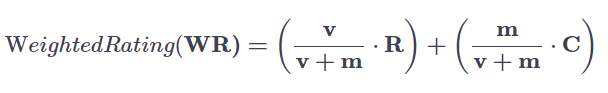

<ul> 
        <li>v: número de votos total do filme</li>
        <li>m: número mínimo de votos para estar listado</li>
        <li>R: rating médio do filme</li>
        <li>C: rating médio total</li>
</ul>

Vamos então recuperar os dados necessários para fazer os calculos posteriormente

##### Pegando average rating de cada filme

In [18]:
# Agrupando pelo ID e fazendo a média do rating de cada filme - agrupamos pelo ID pois cada filme pode ter o mesmo titulo
average_rating = pd.DataFrame(ratings_cb.groupby("movieId").mean()["rating"])

# Voltando o index ao normal
average_rating.reset_index(inplace=True)

# Renomeando coluna
average_rating.rename(columns={"rating": "average rating"}, inplace=True)

average_rating.tail()

,movieId,average rating
59042,209157,1.5
59043,209159,3.0
59044,209163,4.5
59045,209169,3.0
59046,209171,3.0


##### Pegando rating count de cada filme

In [19]:
# Agrupando pelo ID contando quantos votos cada filme tem
count_rating = pd.DataFrame(ratings_cb.groupby("movieId").count()["rating"])

# Voltando o index ao normal
count_rating.reset_index(inplace=True)

# Renomeando coluna
count_rating.rename(columns={"rating": "rating count"},inplace=True)

count_rating.tail()

,movieId,rating count
59042,209157,1
59043,209159,1
59044,209163,1
59045,209169,1
59046,209171,1


####  Agora, efetivamente iremos juntar as informações dos Dataframes sobre ratings

In [20]:
# Juntando DataFrames count_rating e average_rating
rating_infos = pd.merge(average_rating, count_rating)
rating_infos.head()

,movieId,average rating,rating count
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


#### Aqui comprovamos a pouca quantidade de votos para filme com média maxima ou minima

In [21]:
# Mostrando os filmes com nota média = 0.5 ou 5 
rating_infos.loc[rating_infos['average rating'].isin([0.5, 5])]

,movieId,average rating,rating count
5693,5805,0.5,2
9414,27914,5.0,1
9640,31945,5.0,1
15146,80154,0.5,1
15290,80781,0.5,1
...,...,...,...
58911,208597,5.0,1
58963,208795,5.0,1
58979,208859,5.0,1
59033,209137,0.5,1


#### Pegando dados e criando função de calculo de WR

In [22]:
# Calculando rating médio total
C = rating_infos['average rating'].mean()

print("Rating médio total: ", C)

# Definindo numero de votos mínimo (25% mais votados)
m = rating_infos['rating count'].quantile(0.90)
print("Valor de m: ", m)

Rating médio total:  3.071373920951152
Valor de m:  413.0


In [23]:
# Definindo a função que calcula o rating com peso. Parametros (series que indica a linha do filme, numero minimo de votos, rating medio total)
def WeightedRating(movie_row, m=m, C=C):
    v = movie_row['rating count']
    R = movie_row['average rating']
    
    return ((v/(v+m)) * R) + ((m/(v+m)) * C)

In [24]:
# Criando a coluna que contem os ratings com peso
# Para cada coluna ele vai pegar o numero de ratings e o médio, para fazer o calculo utizando a função acima
rating_infos['weighted rating'] = rating_infos.apply(WeightedRating, axis=1)

In [25]:
# Exibindo alguns registros, que agora contém os ratings com peso
rating_infos.loc[(rating_infos['rating count'] > 10000) & (rating_infos['rating count'] < 60000)]

,movieId,average rating,rating count,weighted rating
0,1,3.893708,57309,3.887824
1,2,3.251527,24228,3.248508
2,3,3.142028,11804,3.139640
4,5,3.058434,11714,3.058875
5,6,3.854909,24588,3.841965
...,...,...,...,...
24535,122886,3.739115,12678,3.718049
24543,122904,3.852662,13900,3.830118
28451,134130,4.033416,16489,4.009909
28743,134853,3.932401,13580,3.906988


In [26]:
# Salvando o rating infos para Content Based
rating_infos.to_pickle(PATH_TO_RATINGS_INFOS_CB_FILE)

####  Agora, jutando as informações dos filmes com as sobre ratings

In [37]:
# Fazendo copia
data_cb = movies_cb.copy()

# Juntando dados dos filmes com as informações sobre rating
data_cb = data_cb.merge(rating_infos)

data_cb.head()

,movieId,title,genres,year,average rating,rating count,weighted rating
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3.893708,57309,3.887824
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,3.251527,24228,3.248508
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,3.142028,11804,3.139640
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,2.853547,2523,2.884188
4,5,Father of the Bride Part II,[Comedy],1995,3.058434,11714,3.058875


In [38]:
# Verificando dados estatísticos gerais sobre o dataFrame
data_cb.describe()

,movieId,average rating,rating count,weighted rating
count,59047.000000,59047.000000,59047.000000,59047.000000
mean,120692.748065,3.071374,423.393144,3.099534
std,64452.508194,0.739840,2477.885821,0.149322
min,1.000000,0.500000,1.000000,1.710100
25%,78277.000000,2.687500,2.000000,3.067253
50%,136782.000000,3.150000,6.000000,3.072235
75%,173812.000000,3.500000,36.000000,3.080515
max,209171.000000,5.000000,81491.000000,4.406807


Iremos importar agora tags.csv, genome-scores.csv, genome-tags.csv

### Importando tags.csv, genome-scores.csv e genome-tags.csv

In [27]:
# Importando tags.csv
data_tags = pd.read_csv("dataset/ml-25m/tags.csv")
data_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [28]:
# Importando genome-scores.csv
data_genomeScores = pd.read_csv("dataset/ml-25m/genome-scores.csv")

print("Genome-Scores: ")
data_genomeScores.head()

Genome-Scores: 


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [29]:
# Importando genome-tags.csv
data_genomeTags = pd.read_csv("dataset/ml-25m/genome-tags.csv")

print("Genome-Tags: ")
data_genomeTags.head()

Genome-Tags: 


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


Observando os DataFrames restantes, o primeiro passo é remover a coluna timestamps do DataFrame tags.

In [30]:
# Removendo coluna timestamp
data_tags.pop("timestamp")
data_tags.head()

,userId,movieId,tag
0,3,260,classic
1,3,260,sci-fi
2,4,1732,dark comedy
3,4,1732,great dialogue
4,4,7569,so bad it's good


### O primeiro trabalho a ser feito vai ser com o dataframe feito a partir de tags.csv

Aqui o trabalho é um pouco mais criativo, pois as "tags" são criadas pelos usuários e, algumas delas representam mais opiniões do que outras. Então iremos definir quais iremos manter. Antes desse processo, vamos deixar todas as tags em letras minústucas e remover os parênteses de todas elas.

In [32]:
data_tags_mod = data_tags.copy()

# Deixando todas as tags minusculas para ter um formato mais uniforme
data_tags_mod["tag"] = data_tags_mod["tag"].str.lower()

# Separando todas as tags em uma lista
tags_list = data_tags_mod.tag.unique()
tags_list = tags_list.tolist()
tags_list

['classic',
 'sci-fi',
 'dark comedy',
 'great dialogue',
 "so bad it's good",
 'unreliable narrators',
 'tense',
 'artificial intelligence',
 'philosophical',
 'cliche',
 'musical',
 'horror',
 'unpredictable',
 'oscar (best supporting actress)',
 'adventure',
 'anime',
 'ecology',
 'fantasy',
 'hayao miyazaki',
 'miyazaki',
 'post-apocalyptic',
 'bah',
 'clint eastwood',
 'music',
 'art',
 'contemporary art',
 'documentary',
 'aliens',
 'amazing photography',
 'director: james cameron',
 'first contact',
 'james cameron',
 'michael biehn',
 'android(s)/cyborg(s)',
 'apocalypse',
 'arnold schwarzenegger',
 'franchise',
 'terminator',
 'time travel',
 'science fiction',
 'inferior sequel',
 'setting:london (uk) (future)',
 'unoriginal',
 'bad science',
 'good science',
 'hans zimmer',
 'philosophical issues',
 'space',
 'space travel',
 'time-travel',
 'visually appealing',
 'bittersweet',
 'boring',
 'conversation',
 'dialogue driven',
 'loneliness',
 'love story',
 'philosophy',
 'qu

In [33]:
len(tags_list)

65465

### TRABALHANDO COM LINGUAGEM NATURAL

In [36]:
# Primeiro juntando todas as tags em uma unica linha
data_tags_grouped = data_tags_mod.copy()

data_tags_grouped.fillna("", inplace=True)

# Agrupando as tags em uma linha só
data_tags_grouped = pd.DataFrame(data_tags_grouped.groupby('movieId')['tag'].apply(lambda x: "%s" %' '.join(x)))

# Resetando index
data_tags_grouped.reset_index(inplace=True)
data_tags_grouped.rename(columns={"tag":"tags"}, inplace=True)
pd.set_option('display.max_colwidth', 500)
data_tags_grouped.head()

,movieId,tags
0,1,owned imdb top 250 pixar pixar time travel children comedy funny witty rated-g animation pixar computer animation good cartoon chindren pixar friendship bright daring rescues fanciful heroic mission humorous light rousing toys come to life unlikely friendships warm witty animation disney friendship pixar boy boy next door bullying friends friendship jealousy martial arts mission neighborhood new toy pixar rescue resourcefulness rivalry toy toy comes to life walkie talkie clever animation cle...
1,2,robin williams time travel fantasy based on children's book board game disappearance giant insect new home recluse bad cgi kid flick scary time travel animals bad cgi board game not for kids robin williams time travel fantasy magic board game robin williams kid flick adventure animals board game family fantasy fiction robin williams time travel fantasy robin williams adapted from:book childish children kid flick time travel animals bad cgi based on a book board game chris van allsburg animal...
2,3,funny best friend duringcreditsstinger fishing old man sequel fever moldy old sequel no_fa_ganes jack lemmon walter matthau grun running comedinha de velhinhos engraãƒâ§ada old people that is actually funny howard deutch clv sequel comedinha de velhinhos engraã§ada moldy old ann margaret burgess meredith daryl hannah fishing good soundtrack jack lemmon sophia loren walter matthau
3,4,based on novel or book chick flick divorce interracial relationship single mother clv chick flick revenge characters characters chick flick
4,5,aging baby confidence contraception daughter gynecologist midlife crisis parent child relationship pregnancy sequel fever fantasy steve martin comedy touching clv steve martin family pregnancy wedding diane keaton family sequel steve martin wedding


#### PROCESSANDO OS METADADOS FORMADOS PELA JUNÇÃO DE TAGS

In [46]:
pd.set_option('display.max_colwidth', 50)

# SETANDO CONFIGURACOES PARA PROCESSAR AS TAGS
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
  
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
  
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
  
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SeaSkyThe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SeaSkyThe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SeaSkyThe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SeaSkyThe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# CRIANDO FUNCAO PARA PROCESSAR AS TAGS, TIRANDO CONTRAÇÕES DE PALAVRAS (n't = not)

def preprocess_sentences(text):
    # garantindo que o texto seja minusculo (apesar de já termos feito isso)
    text = text.lower()
    temp_sent = []
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES:
            lemmatized = lemmatizer.lemmatize(word, 'v')
        else:
            lemmatized = lemmatizer.lemmatize(word)
        if lemmatized not in stop_words and lemmatized.isalpha():
            temp_sent.append(lemmatized)
    
    finalsent = ' '.join(temp_sent)
    finalsent = finalsent.replace("n't", " not")
    finalsent = finalsent.replace("'m", " am")
    finalsent = finalsent.replace("'s", " is")
    finalsent = finalsent.replace("'re", " are")
    finalsent = finalsent.replace("'ll", " will")
    finalsent = finalsent.replace("'ve", " have")
    finalsent = finalsent.replace("'d", " would")
    return finalsent

data_tags_grouped["tags_processed"]= data_tags_grouped["tags"].apply(preprocess_sentences)
data_tags_grouped.tail()

,movieId,tags,tags_processed
45246,208813,might like,might like
45247,208933,black and white deal with the devil,black white deal devil
45248,209035,computer animation japan mass behavior mass sc...,computer animation japan mass behavior mass sc...
45249,209037,chameleon computer animation gluttony humorous...,chameleon computer animation gluttony humorous...
45250,209063,black education friends schools independent sc...,black education friend school independent scho...


In [48]:
pd.set_option('display.max_colwidth', 500)
data_tags_grouped.head(15)

,movieId,tags,tags_processed
0,1,owned imdb top 250 pixar pixar time travel children comedy funny witty rated-g animation pixar computer animation good cartoon chindren pixar friendship bright daring rescues fanciful heroic mission humorous light rousing toys come to life unlikely friendships warm witty animation disney friendship pixar boy boy next door bullying friends friendship jealousy martial arts mission neighborhood new toy pixar rescue resourcefulness rivalry toy toy comes to life walkie talkie clever animation cle...,imdb top pixar pixar time travel child comedy funny witty animation pixar computer animation good cartoon chindren pixar friendship bright dare rescue fanciful heroic mission humorous light rouse toy come life unlikely friendship warm witty animation disney friendship pixar boy boy next door bully friend friendship jealousy martial art mission neighborhood new toy pixar rescue resourcefulness rivalry toy toy come life walkie talkie clever animation clever friendship funny tom hank witty pixa...
1,2,robin williams time travel fantasy based on children's book board game disappearance giant insect new home recluse bad cgi kid flick scary time travel animals bad cgi board game not for kids robin williams time travel fantasy magic board game robin williams kid flick adventure animals board game family fantasy fiction robin williams time travel fantasy robin williams adapted from:book childish children kid flick time travel animals bad cgi based on a book board game chris van allsburg animal...,robin williams time travel fantasy base child book board game disappearance giant insect new home recluse bad cgi kid flick scary time travel animal bad cgi board game kid robin williams time travel fantasy magic board game robin williams kid flick adventure animal board game family fantasy fiction robin williams time travel fantasy robin williams adapt book childish child kid flick time travel animal bad cgi base book board game chris van allsburg animal fantasy robin williams scary robin w...
2,3,funny best friend duringcreditsstinger fishing old man sequel fever moldy old sequel no_fa_ganes jack lemmon walter matthau grun running comedinha de velhinhos engraãƒâ§ada old people that is actually funny howard deutch clv sequel comedinha de velhinhos engraã§ada moldy old ann margaret burgess meredith daryl hannah fishing good soundtrack jack lemmon sophia loren walter matthau,funny best friend duringcreditsstinger fish old man sequel fever moldy old sequel jack lemmon walter matthau grun run comedinha de velhinhos old people actually funny howard deutch clv sequel comedinha de velhinhos moldy old ann margaret burgess meredith daryl hannah fish good soundtrack jack lemmon sophia loren walter matthau
3,4,based on novel or book chick flick divorce interracial relationship single mother clv chick flick revenge characters characters chick flick,base novel book chick flick divorce interracial relationship single mother clv chick flick revenge character character chick flick
4,5,aging baby confidence contraception daughter gynecologist midlife crisis parent child relationship pregnancy sequel fever fantasy steve martin comedy touching clv steve martin family pregnancy wedding diane keaton family sequel steve martin wedding,age baby confidence contraception daughter gynecologist midlife crisis parent child relationship pregnancy sequel fever fantasy steve martin comedy touch clv steve martin family pregnancy wed diane keaton family sequel steve martin wedding
5,6,imdb top 250 great acting realistic action suspense al pacino atmospheric bank robbery crime great acting realistic action robert de niro suspense tense val kilmer bank job bank robbery crime dialogue heist heist movie long al pacino atmospheric realistic action robert de niro bank robbery los angeles realistic action al pacino atmospheric michael mann realistic action robert de niro visceral atmospheric bleak slick somber tense visceral witty bank job betrayal cat and m

In [49]:
# Salvando arquivo de tags processadas
data_tags_grouped.to_pickle(PATH_TO_TAGS_PROCESSED_CB_FILE)

#### O resto é feito no protótipo 2 (Vetorização e Criação do modelo)

#### Separando da lista de tags, apenas as que são relevantes, o critério será explicado posteriormente

## OBS: isso foi feito acima de maneira automatica com tratamento de linguagem natural

In [87]:
tags_list_mod = tags_list.copy()
tags_list_mod = [str(i) for i in tags_list_mod]

for tag in tags_list_mod:
    # Removendo parenteses e seus conteudos
    corrected_tag = re.sub(r' \([^)]*\)', '', tag)
    #print(corrected_tag)
    # "based" é um palavra comum de estar nas tags, e vai evitar cair em outros ifs
    if 'based' in corrected_tag:
        tags_list_mod[tags_list_mod.index(tag)] = corrected_tag
        continue
    # esse é para manter a tag sci-fi, e evita-la de ser removida no proximo if
    if '-' in corrected_tag:
        tags_list_mod[tags_list_mod.index(tag)] = corrected_tag
        continue
    
   
    if re.findall(r'\b\w{2}\b', corrected_tag):
        #todas as palavras de duas letras serão substituidas por NaN, que serão removidos depois
        tags_list_mod[tags_list_mod.index(tag)] = 'nan'
    
    elif re.findall(r'\b\w{1}\b', corrected_tag):
        #todas as palavras de uma letra serão substituidas por NaN, que serão removidos depois
        tags_list_mod[tags_list_mod.index(tag)] = 'nan'
    
    #remover as tags que são sites
    elif("www" in corrected_tag):
        tags_list_mod[tags_list_mod.index(tag)] = 'nan'
        
    elif tag == corrected_tag:
        #evitar substituição desnecessária
        continue
    
    else:
        tags_list_mod[tags_list_mod.index(tag)] = corrected_tag
        pass

tags_list_mod = [x for x in tags_list_mod if x != 'nan']

In [96]:
def hasDigit(inputString):
    return any(char.isdigit() for char in inputString)

for x in tags_list_mod:
    if hasDigit(x) and "-" in x:
        print(x)

written by a 14-year-old boy
stereoscopic 3-d
55 movies every kid should see--entertainment weekly
3-hours of sex and drugs
pg-13
pg-13 horror
bb-8
dimensionalized 2-d to 3-d
rated-pg-13
bosnian war of 1992-1995
super-8
based on 4-koma
nc-17
2-dimensional
pg-13:sci-fi action violence
qotd is the 3rd book - they squeezed the vampire lestat into 20 minutes of film
notable nc-17
watered-down pg-13 horror
car: austin-healey 3000
the first film to receive nc-17 rating
pg-13:brief strong language
pg-13:some sexuality
pg-13:thematic elements
r2-d2
90s sci-fi
pg-13:nudity
attack of the 50-foot whatever
the 5-second rule never applies near animals or in zoos
karl urban needs to pick better projects & he needs 2 pick-up his sword
super-35 blow-up
28 days later rip-off
blu-ray 3d
70s sci-fi
6.3-filmaffinity
pg-13:some sexual material
pg-13:sequences of sci-fi action and violence
9-11
c-3po
7.5-filmaffinity
7.2-filmaffinity
6,5-filmaffinity
8.7-filmaffinity
7.4-filmaffinity
8.4-filmaffinity
8.2-fi

Removemos as datas nesses formatos
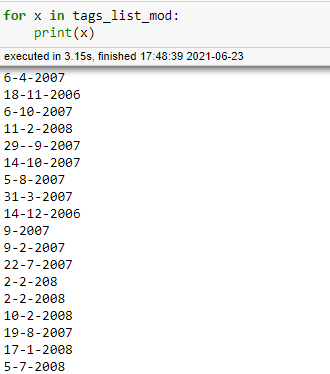

E tags com esse formato:
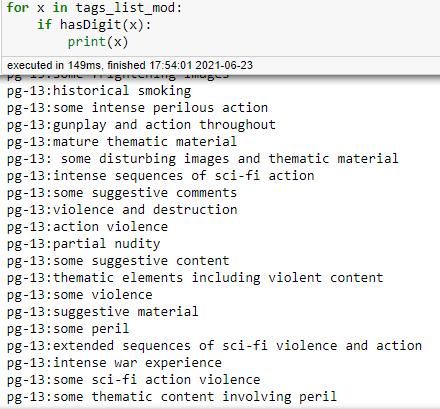

In [ ]:
for index, row in data_tags_mod.iterrows():
    tag = row.tag
    
    # Removendo parenteses e seus conteudos
    corrected_tag = re.sub(r' \([^)]*\)', '', tag)
    
    # "based" é um palavra comum de estar nas tags, e vai evitar cair em outros ifs
    if 'based' in corrected_tag:
        data_tags_mod.loc[index, 'tag'] = corrected_tag
        continue
    # esse é para manter a tag sci-fi, e evita-la de ser removida no proximo if
    if '-' in corrected_tag:
        data_tags_mod.loc[index, 'tag'] = corrected_tag
        continue
    
    if re.findall(r'\b\w{2}\b', corrected_tag):
        #todas as palavras de duas letras serão substituidas por NaN, que serão removidos depois
        data_tags_mod.loc[index, 'tag'] = np.NaN
    
    elif re.findall(r'\b\w{1}\b', corrected_tag):
        #todas as palavras de uma letra serão substituidas por NaN, que serão removidos depois
        data_tags_mod.loc[index, 'tag'] = np.NaN
        
    elif tag == corrected_tag:
        #evitar substituição desnecessária
        continue
    
    else:
        data_tags_mod.loc[index, 'tag'] = corrected_tag
        pass

# remove todas as tags q são palavras de duas letras ou menos
data_tags_mod = data_tags_mod.dropna()

Foram removidas todas as tags que continham palavras de duas ou uma letra, pois elas costumam não representar bem o filme. Exceto as "sci-fi" e as que contem "based", pois elas tem palavras de 2 letras e são importantes. (based on)

### O processamento de tags.csv foi finalizado acima, agora trabalharemos com os genomes.

Agora vamos adicionar o nome da tag (presente em genome-tags) à tabela de scores.

In [50]:
# Fazendo o merge dos dois DataFrames
data_scores = pd.merge(data_genomeScores, data_genomeTags)
data_scores = data_scores[["movieId", "tagId", "tag", "relevance"]]

print("Genome-Scores + Genome-Tags: ")
data_scores.head()

Genome-Scores + Genome-Tags: 


,movieId,tagId,tag,relevance
0,1,1,007,0.02875
1,2,1,007,0.04125
2,3,1,007,0.04675
3,4,1,007,0.03425
4,5,1,007,0.04300


#### Como podemos observar, os valores de relevância para cada tag são valores contínuos. Para a abordagem Content-Based, é bom que tenhamos valores discretos para as características, desse modo, teremos então que agrupar os valores de relevância em categorias, podendo ser elas:

#### \begin{equation} 0 \leq relevance < 0.25 = 1\end{equation}
#### \begin{equation} 0.25 \leq relevance < 0.5 = 2\end{equation}
#### \begin{equation} 0.5 \leq relevance < 0.75 = 3\end{equation}
#### \begin{equation} 0.75 \leq relevance  \leq 1 = 4\end{equation}


#### Pode-se aumentar o numero de categorias para ter um modelo mais preciso

In [51]:
# Vamos separar nos grupos de relevancia
# Copiando
data_tagRelevance = data_scores.copy()
# Separando Grupo 1
data_tagRelevance.loc[(data_tagRelevance.relevance < 0.25) & (data_tagRelevance.relevance >= 0), "relevance"] = 1
# Separando Grupo 2
data_tagRelevance.loc[(data_tagRelevance.relevance < 0.50) & (data_tagRelevance.relevance >= 0.25), "relevance"] = 2
# Separando Grupo 3
data_tagRelevance.loc[(data_tagRelevance.relevance < 0.75) & (data_tagRelevance.relevance >= 0.50), "relevance"] = 3
# Separando Grupo 4
data_tagRelevance.loc[(data_tagRelevance.relevance < 1.0) & (data_tagRelevance.relevance >= 0.75), "relevance"] = 4

data_tagRelevance.head(10)

,movieId,tagId,tag,relevance
0,1,1,007,1.0
1,2,1,007,1.0
2,3,1,007,1.0
3,4,1,007,1.0
4,5,1,007,1.0
5,6,1,007,1.0
6,7,1,007,1.0
7,8,1,007,1.0
8,9,1,007,1.0
9,10,1,007,4.0


In [52]:
data_tagRelevance.value_counts("movieId")

movieId
1         1128
57326     1128
57368     1128
57370     1128
57393     1128
          ... 
5107      1128
5108      1128
5109      1128
5110      1128
206499    1128
Length: 13816, dtype: int64

In [53]:
data_tagRelevance.value_counts("movieId")

movieId
1         1128
57326     1128
57368     1128
57370     1128
57393     1128
          ... 
5107      1128
5108      1128
5109      1128
5110      1128
206499    1128
Length: 13816, dtype: int64

#### Transformaremos o DataFrame em um formato agrupado, com listas.

In [54]:
# Transformando o DataFrame, agrupando em listas com os valores de relevancia para cada Tag

# Agrupando por movie Id, e fazendo uma lista das tags
data_tagRelevanceGrouped = pd.DataFrame(data_tagRelevance.groupby(by="movieId", axis=0)["tag"].apply(list))
# Agrupando por movie Id, e fazendo uma lista dos grupos de relevancia
data_tagRelevanceGrouped["relevance"] = pd.DataFrame(data_tagRelevance.groupby(by="movieId", axis=0)["relevance"].apply(list))
# Resetando index
data_tagRelevanceGrouped.reset_index(inplace=True)

data_tagRelevanceGrouped.head()

,movieId,tag,relevance
0,1,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,2,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, ..."
2,3,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,4,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [55]:
data_tagRelevanceGrouped.tail()

,movieId,tag,relevance
13811,205072,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, ..."
13812,205076,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13813,205383,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
13814,205425,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [56]:
# Salvando as relevancias de tag agrupadas
data_tagRelevanceGrouped.to_pickle(PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE)

#### Criando um dataframe igual ao anterior, porém com os valores de relevancia originais

In [57]:
# Transformando o DataFrame, agrupando em listas com os valores de relevancia para cada Tag

# Agrupando por movie Id, e fazendo uma lista das tags
data_tagGrouped = pd.DataFrame(data_scores.groupby(by="movieId", axis=0)["tag"].apply(list))
# Agrupando por movie Id, e fazendo uma lista dos grupos de relevancia
data_tagGrouped["relevance"] = pd.DataFrame(data_scores.groupby(by="movieId", axis=0)["relevance"].apply(list))
# Resetando index
data_tagGrouped.reset_index(inplace=True)

data_tagGrouped.head()

,movieId,tag,relevance
0,1,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.0287499999999999, 0.0237499999999999, 0.0625, 0.0757499999999999, 0.14075, 0.14675, 0.0635, 0.20375, 0.202, 0.03075, 0.58025, 0.1024999999999999, 0.2017499999999999, 0.007, 0.0245, 0.17275, 0.0165, 0.1039999999999999, 0.6625, 0.3007499999999999, 0.31675, 0.286, 0.0627499999999999, 0.0192499999999999, 0.05875, 0.0792499999999999, 0.1965, 0.09325, 0.89375, 0.67625, 0.03575, 0.23325, 0.3075, 0.0544999999999999, 0.0379999999999999, 0.212, 0.08, 0.0155, 0.0195, 0.0192499999999999, 0.015, 0.03,..."
1,2,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.04125, 0.0404999999999999, 0.0627499999999999, 0.0827499999999999, 0.091, 0.06125, 0.0692499999999999, 0.0959999999999999, 0.0765, 0.0524999999999999, 0.088, 0.10275, 0.14525, 0.007, 0.0045, 0.0275, 0.0107499999999999, 0.15925, 0.64025, 0.3672499999999999, 0.5145, 0.4845, 0.1972499999999999, 0.24875, 0.0832499999999999, 0.1569999999999999, 0.1455, 0.05825, 0.976, 0.1267499999999999, 0.0105, 0.0735, 0.0707499999999999, 0.069, 0.10975, 0.2977499999999999, 0.062, 0.02, 0.0275, 0.017249999999..."
2,3,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.04675, 0.0554999999999999, 0.0292499999999999, 0.087, 0.0474999999999999, 0.04775, 0.0459999999999999, 0.14275, 0.0285, 0.03875, 0.0245, 0.0647499999999999, 0.081, 0.0055, 0.005, 0.03475, 0.0067499999999999, 0.11375, 0.16025, 0.14075, 0.252, 0.1937499999999999, 0.10425, 0.0167499999999999, 0.04875, 0.0645, 0.1317499999999999, 0.08625, 0.3215, 0.0954999999999999, 0.012, 0.03575, 0.05975, 0.0662499999999999, 0.0529999999999999, 0.2857499999999999, 0.05275, 0.029, 0.0364999999999999, 0.0175,..."
3,4,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.03425, 0.0379999999999999, 0.0404999999999999, 0.031, 0.065, 0.03575, 0.029, 0.0865, 0.0319999999999999, 0.0314999999999999, 0.028, 0.03475, 0.0777499999999999, 0.0132499999999999, 0.0032499999999999, 0.0265, 0.0187499999999999, 0.1337499999999999, 0.147, 0.11025, 0.507, 0.46175, 0.1099999999999999, 0.017, 0.0745, 0.06075, 0.1252499999999999, 0.61775, 0.14875, 0.1315, 0.0135, 0.0404999999999999, 0.0524999999999999, 0.03725, 0.0454999999999

In [58]:
data_tagGrouped.tail()

,movieId,tag,relevance
13811,205072,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.0205, 0.0177499999999999, 0.1139999999999999, 0.0364999999999999, 0.31225, 0.03675, 0.1069999999999999, 0.37925, 0.0172499999999999, 0.3635, 0.064, 0.0464999999999999, 0.23275, 0.0047499999999999, 0.0057499999999999, 0.0712499999999999, 0.0167499999999999, 0.15425, 0.22675, 0.1952499999999999, 0.38525, 0.2847499999999999, 0.0875, 0.0237499999999999, 0.16625, 0.05325, 0.23125, 0.0949999999999999, 0.24975, 0.353, 0.0197499999999999, 0.33425, 0.15475, 0.0155, 0.0082499999999999, 0.0424999999..."
13812,205076,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.03825, 0.0314999999999999, 0.0319999999999999, 0.05325, 0.2085, 0.0705, 0.0662499999999999, 0.27825, 0.0095, 0.0275, 0.0305, 0.04225, 0.0459999999999999, 0.0067499999999999, 0.0802499999999999, 0.55225, 0.0185, 0.16575, 0.0964999999999999, 0.0777499999999999, 0.17925, 0.204, 0.0652499999999999, 0.0147499999999999, 0.0969999999999999, 0.24325, 0.10125, 0.1104999999999999, 0.124, 0.3482499999999999, 0.04725, 0.2534999999999999, 0.085, 0.028, 0.0257499999999999, 0.03075, 0.1215, 0.009, 0.004..."
13813,205383,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.0409999999999999, 0.04025, 0.0275, 0.0785, 0.1975, 0.17825, 0.17125, 0.3047499999999999, 0.16825, 0.0484999999999999, 0.04275, 0.03675, 0.22075, 0.0115, 0.0042499999999999, 0.05025, 0.0202499999999999, 0.41825, 0.285, 0.27425, 0.52525, 0.23575, 0.087, 0.0145, 0.0705, 0.1375, 0.0979999999999999, 0.1134999999999999, 0.1887499999999999, 0.1945, 0.0122499999999999, 0.0554999999999999, 0.0459999999999999, 0.0685, 0.0964999999999999, 0.0974999999999999, 0.04625, 0.0275, 0.0499999999999999, 0.03..."
13814,205425,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[0.04525, 0.04125, 0.0424999999999999, 0.0742499999999999, 0.1154999999999999, 0.1049999999999999, 0.0827499999999999, 0.1357499999999999, 0.16125, 0.05875, 0.03875, 0.04525, 0.2744999999999999, 0.0142499999999999, 0.0045, 0.06075, 0.0275, 0.34225, 0.26225, 0.16775, 0.4429999999999999, 0.3055, 0.1009999999999999, 0.0125, 0.2865, 0.1475, 0.27825, 0.148, 0.23975, 0.494, 0.0285, 0.36, 0.3255, 0.04625, 0.0275, 

In [59]:
# Salvando as relevancias de tags
data_tagGrouped.to_pickle(PATH_TO_TAG_RELEVANCE_CB_FILE)

In [60]:
#data_cb_final = pd.merge(data_cb, data_tagRelevanceGrouped)
data_cb_final = pd.merge(data_cb, data_tagRelevanceGrouped)
data_cb_final.head()

,movieId,title,genres,year,average rating,rating count,weighted rating,tag,relevance
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3.893708,57309,3.887824,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,3.251527,24228,3.248508,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, ..."
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,3.142028,11804,3.139640,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,2.853547,2523,2.884188,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [61]:
data_cb_final.tail()

,movieId,title,genres,year,average rating,rating count,weighted rating,tag,relevance
13811,205072,Zombieland: Double Tap,"[Action, Comedy, Horror]",2019,3.310345,58,3.100801,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, ..."
13812,205076,Downton Abbey,[Drama],2019,3.216981,53,3.087934,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13813,205383,El Camino: A Breaking Bad Movie,"[Crime, Drama, Thriller]",2019,3.642857,252,3.287936,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
13814,205425,Dave Chappelle: Sticks & Stones,[Comedy],2019,3.543478,69,3.138957,"[007, 007 (series), 18th century, 1920s, 1930s, 1950s, 1960s, 1970s, 1980s, 19th century, 3d, 70mm, 80s, 9/11, aardman, aardman studios, abortion, absurd, action, action packed, adaptation, adapted from:book, adapted from:comic, adapted from:game, addiction, adolescence, adoption, adultery, adventure, affectionate, afi 100, afi 100 (laughs), afi 100 (movie quotes), africa, afterlife, aging, aids, airplane, airport, alaska, alcatraz, alcoholism, alien, alien invasion, aliens, allegory, almodo...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 

In [62]:
# Salvando em .pickle o arquivo final
data_cb_final.to_pickle(PATH_TO_FULL_CB_FILE)

# COMO SALVAR MANTENDO AS ESTRUTURAS E TIPOS DE DADOS
## Save to pickle
df.to_pickle('pickle-file.pkl')
## Save with compression
df.to_pickle('pickle-file.pkl.gz', compression='gzip')

## Load pickle from disk
df = pd.read_pickle('pickle-file.pkl')   # or...
df = pd.read_pickle('pickle-file.pkl.gz', compression='gzip')

In [ ]:
# Plotar histograma da distribuição de notas
plt.hist(averageRating_df['average rating'])
plt.show()

In [ ]:
# Plotando histrograma da distribuição de notas com peso
plt.hist(averageRating_df['weighted rating'])
plt.show()

Nota-se a grande concentração da quantidade de votos no intervalo de 0 à 18000

In [ ]:
sns.lmplot(x="number of ratings", y="average rating", data=averageRating_df)
plt.show()

### Recuperar dados dos filmes do IMDb utilizando o imdbpy, para incrementar ainda mais os dados sobre os filmes.

Cada filme registrado no IMDb tem um ID associado a ele, e o arquivo "links.csv", disponibilizado pelo MovieLens, trás todos os IDs relativos ao IMDb, o que irá nos auxiliar a recuperar os dados de cada filme.

In [ ]:
movies[0:2].head()

In [ ]:
# Criando objeto que irá fazer o web scraping
imdb = IMDb()
# Como a função do imdbpy "get_movie" utiliza os IDs dos filmes como parâmetro, iremos utilizar o DataFrame links
# Criando o dataframe que irá guardar todas essas informações (pegaremos elenco (cast), diretores (directors), produtores(producers))

# Criando o dicionario que irá armazenar as informações e posteriormente se tornará um DataFrame
infos = {}

# Pegando titulos do DataFrame "movies", e para cada titulo, criamos uma chave no dicionário, que irá ser da seguinte forma
# {"titulo": [cast, directors, producers]}, onde cast, directors e producers são listas

for row in movies[0:10].itertuples():
    infos[row.movieId] = [row.title, row.genres, row.year, [], [], []]

# Para cada linha no dataFrame "links" pesquisamos o filme no Imdb, recuperamos as informações extras e colocamos dentro do dict
for row in links[0:10].itertuples():
    movie = imdb.get_movie(row.imdbId, info=['main'])
    
    
    for actor in movie['cast']:
        # posição 3 da lista armazenada no dicionário é onde fica o cast
        infos[row.movieId][3].append(actor['name'])
    
    for director in movie['directors']:
        # posição 4 da lista armazenada no dicionário é onde fica os directors
        infos[row.movieId][4].append(director['name'])
        
    for producer in movie['producers']:
        # posição 5 da lista armazenada no dicionário é onde fica os producers
        infos[row.movieId][5].append([producer['name']])
    

moviesWithMoreInfo = pd.DataFrame.from_dict(infos, orient='index', columns=['title', 'year','genres', 'cast', 'directors', 'producers'])

moviesWithMoreInfo.head()

### 3 - Sistema de recomendação CF

In [ ]:
# Importando bibliotecas para o sistema de recomendação
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Transformando a nossa matriz em uma mais eficiente utilizando o método csr (compressed sparse row matrix)
user_movie_matrix_csr = csr_matrix(user_movie_matrix.values)

In [ ]:
user_movie_matrix_csr.getrow(0).todense()

In [ ]:
# Criando o modelo knn
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine') # temos que mexer nos parâmetros posteriormente

knn.fit(user_movie_matrix_csr)

In [ ]:
movies_titles_list = []

for title in data_movies["title"]:
    movies_titles_list.append(title)
    
# criando função que gera recomendações basedo em um filme
def get_recomendations(movie_name):  
    distances, suggestions = knn.kneighbors(user_movie_matrix.loc[movie_name].values.reshape(1, -1), n_neighbors=5)

    for i in range(0, len(distances.flatten())):
        if(i == 0):
            print('Recomendações para {0}: \n'.format(movie_name))
        else:
            print('{0}: {1}, com distância de {2}:'.format(i, user_movie_matrix.index[suggestions.flatten()[i]], distances.flatten()[i]))


In [ ]:
# definindo função para pesquisar o nome correto do filme que está na matriz - lembrando que nem todo filme que está
# no dataset está na matriz, pois precisamos usar apenas uma porção

def search_movies_matrix(search_word):
    return user_movie_matrix[user_movie_matrix.index.str.contains(search_word, flags=re.IGNORECASE)]

# Função para pesquisar um filme dentro do dataset
def search_movies(search_word):
    return data_movies[data_movies.title.str.contains(search_word, flags=re.IGNORECASE)]

In [ ]:
# Procurando filmes geral
search_movies("Ace Ventura: When Nature Calls")

In [ ]:
# Procurando filmes na matriz
search_movies_matrix("Ace ")

In [ ]:
# Observando acima, queremos The Godfather - "Godfather, The"
get_recomendations("Ace Ventura: When Nature Calls")

In [ ]:
data_movies.loc[data_movies["title"] == "Braveheart"]